# Hyperparameter Tuning

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from wildfireassessment.grid import * 
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, classification_report
import pickle
from sklearn.externals import joblib
from pathlib import Path
import scipy

/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
filepathX = Path("./data/X_v2.npy")
filepathy = Path("./data/y_v2.npy")

X = np.load(filepathX)
y = np.load(filepathy)

In [4]:
# stratified shuffle 50/50 train/test split -- don't want too many since exhaustive grid search
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, shuffle=True, stratify=y)

In [5]:
print("train shape: ", X_train.shape)
print("test shape: ", X_test.shape)

print("\n# of burn labels in train: ", np.count_nonzero(y_train))
print("# of non-burn labels in train: ", y_train.shape[0]-np.count_nonzero(y_train))
print("# of burn labels in test: ", np.count_nonzero(y_test))
print("# of non-burn labels in test: ", y_test.shape[0]-np.count_nonzero(y_test))

train shape:  (7043, 26)
test shape:  (7043, 26)

# of burn labels in train:  4520
# of non-burn labels in train:  2523
# of burn labels in test:  4519
# of non-burn labels in test:  2524


## Random Forest Parameter Tuning

### Randomized Search

In [8]:
scores = ['accuracy', 'precision', 'recall', 'f1']

In [7]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 2000, num = 20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [9]:
%pprint
random_grid

Pretty printing has been turned ON


{'n_estimators': [10,
  114,
  219,
  324,
  428,
  533,
  638,
  743,
  847,
  952,
  1057,
  1162,
  1266,
  1371,
  1476,
  1581,
  1685,
  1790,
  1895,
  2000],
 'max_features': ['auto', 'sqrt', 'log2'],
 'max_depth': [10, 19, 28, 37, 46, 55, 64, 73, 82, 91, 100, None],
 'min_samples_split': [2, 5, 10, 15, 100],
 'min_samples_leaf': [1, 2, 5, 10],
 'bootstrap': [True, False]}

In [10]:
%%time
gridSearch(RandomForestClassifier(), random_grid, scores, X_train, y_train, X_test, y_test, refit='precision', filename="rf_rand_bin", cv=5, random=True, n_iter=25)

# Tuning hyper-parameters for precision

Random ON
Fitting model...
Best parameters set found on development set:

{'n_estimators': 533, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False}

Grid scores on development set:

Scorer: accuracy

0.850 (+/-0.021) for {'n_estimators': 324, 'min_samples_split': 100, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 46, 'bootstrap': True}
0.856 (+/-0.013) for {'n_estimators': 10, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
0.863 (+/-0.015) for {'n_estimators': 533, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'max_depth': 46, 'bootstrap': False}
0.858 (+/-0.010) for {'n_estimators': 10, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 82, 'bootstrap': False}
0.866 (+/-0.012) for {'n_estimators': 743, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max

              precision    recall  f1-score   support

           0       0.85      0.77      0.81      2524
           1       0.88      0.93      0.90      4519

    accuracy                           0.87      7043
   macro avg       0.87      0.85      0.85      7043
weighted avg       0.87      0.87      0.87      7043


Saving best model to file: models/rf_rand_bin_precision.pkl
CPU times: user 16.9 s, sys: 241 ms, total: 17.2 s
Wall time: 2min 20s


### Grid Search

In [18]:
[int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]

[200, 650, 1100, 1550, 2000]

In [13]:
[i for i in range(500, 1600, 200)]

[500, 700, 900, 1100, 1300, 1500]

In [19]:
# Create the parameter grid
full_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [55, 70, 80, 90],
               'min_samples_split': [5, 10],
               'min_samples_leaf': [1, 2, 5],
               'bootstrap': [True, False]}
full_grid

{'n_estimators': [200, 650, 1100, 1550, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [55, 70, 80, 90],
 'min_samples_split': [5, 10],
 'min_samples_leaf': [1, 2, 5],
 'bootstrap': [True, False]}

In [20]:
%%time
gridSearch(RandomForestClassifier(), full_grid, scores, X_train, y_train, X_test, y_test, refit='precision', filename="rf_grid_bin", cv=5)

# Tuning hyper-parameters for precision

Fitting model...


/home/ec2-user/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best parameters set found on development set:

{'bootstrap': False, 'max_depth': 70, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

Grid scores on development set:

Scorer: accuracy

0.867 (+/-0.013) for {'bootstrap': True, 'max_depth': 55, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
0.867 (+/-0.013) for {'bootstrap': True, 'max_depth': 55, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 650}
0.868 (+/-0.014) for {'bootstrap': True, 'max_depth': 55, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1100}
0.866 (+/-0.013) for {'bootstrap': True, 'max_depth': 55, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1550}
0.867 (+/-0.012) for {'bootstrap': True, 'max_depth': 55, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 2000}
0.863 (+/-0.016) f

              precision    recall  f1-score   support

           0       0.85      0.77      0.81      2524
           1       0.88      0.92      0.90      4519

    accuracy                           0.87      7043
   macro avg       0.86      0.85      0.85      7043
weighted avg       0.87      0.87      0.87      7043


Saving best model to file: models/rf_grid_bin_precision.pkl
CPU times: user 14.5 s, sys: 803 ms, total: 15.3 s
Wall time: 43min 22s


## MLP Parameter Tuning

### Grid Search

In [6]:
# Hidden layer sizes
hidden_layers = [(50,50,50), (50,100,50), (100,)]
# Activation functions
activations = ['identity', 'logistic', 'tanh', 'relu']
# Solver
solvers = ['lbfgs', 'sgd', 'adam']
# Alpha
alphas = [0.0001, 0.05]
# Learning Rates
learning_rates = ['constant', 'adaptive', 'invscaling']

# Create the random grid
grid = {'hidden_layer_sizes': hidden_layers,
               'activation': activations,
               'solver': solvers,
               'alpha': alphas,
               'learning_rate': learning_rates}
grid

{'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50), (100,)],
 'activation': ['identity', 'logistic', 'tanh', 'relu'],
 'solver': ['lbfgs', 'sgd', 'adam'],
 'alpha': [0.0001, 0.05],
 'learning_rate': ['constant', 'adaptive', 'invscaling']}

In [9]:
%%time
gridSearch(MLPClassifier(), grid, scores, X_train, y_train, X_test, y_test, refit='precision', filename="mlp_grid_bin", cv=5, n_jobs=-1)

# Tuning hyper-parameters for precision

Fitting model...
Best parameters set found on development set:

{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'sgd'}

Grid scores on development set:

Scorer: accuracy

0.358 (+/-0.000) for {'activation': 'identity', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'lbfgs'}
0.781 (+/-0.011) for {'activation': 'identity', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'sgd'}
0.784 (+/-0.018) for {'activation': 'identity', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
0.354 (+/-0.016) for {'activation': 'identity', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'lbfgs'}
0.781 (+/-0.011) for {'activation': 'identity', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 

## KNN Parameter Tuning

In [112]:
# stratified shuffle 50/50 train/test split -- don't want too many since exhaustive grid search
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True, stratify=y)

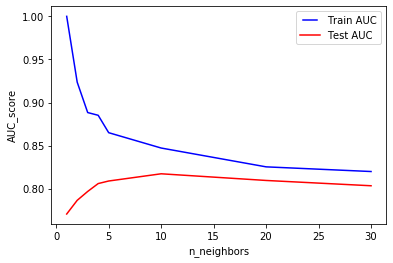

In [118]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
%matplotlib inline
neighbors = [1, 2, 3, 4, 5, 10, 20, 30]
train_results = []
test_results = []
for n in neighbors:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    train_pred = knn.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = knn.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(neighbors, train_results, 'b', label="Train AUC")
line2, = plt.plot(neighbors, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC_score')
plt.xlabel('n_neighbors')
plt.show()

In [14]:
# k neighbors
kneighbors = [int(x) for x in np.linspace(start = 5, stop = 15, num = 5)]
# Power
ps = [1, 2, 3, 4, 5]
# Weights
weights = ['uniform', 'distance']
# Algorithms
algorithms = ['auto', 'ball_tree', 'kd_tree', 'brute']
n_jobs = [-1]

# Create the random grid
grid = {'n_neighbors': kneighbors,
               'p': ps,
               'weights': weights,
               'algorithm': algorithms,
               'n_jobs': n_jobs}
grid

{'n_neighbors': [5, 7, 10, 12, 15],
 'p': [1, 2, 3, 4, 5],
 'weights': ['uniform', 'distance'],
 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
 'n_jobs': [-1]}

In [16]:
%%time
gridSearch(KNeighborsClassifier(), grid, scores, X_train, y_train, X_test, y_test, refit='precision', filename="knn_grid_bin", cv=5, n_jobs=-1)

# Tuning hyper-parameters for precision

Fitting model...


/home/ec2-user/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best parameters set found on development set:

{'algorithm': 'auto', 'n_jobs': -1, 'n_neighbors': 10, 'p': 4, 'weights': 'uniform'}

Grid scores on development set:

Scorer: accuracy

0.826 (+/-0.017) for {'algorithm': 'auto', 'n_jobs': -1, 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
0.827 (+/-0.017) for {'algorithm': 'auto', 'n_jobs': -1, 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
0.826 (+/-0.012) for {'algorithm': 'auto', 'n_jobs': -1, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
0.827 (+/-0.012) for {'algorithm': 'auto', 'n_jobs': -1, 'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
0.828 (+/-0.018) for {'algorithm': 'auto', 'n_jobs': -1, 'n_neighbors': 5, 'p': 3, 'weights': 'uniform'}
0.829 (+/-0.016) for {'algorithm': 'auto', 'n_jobs': -1, 'n_neighbors': 5, 'p': 3, 'weights': 'distance'}
0.830 (+/-0.020) for {'algorithm': 'auto', 'n_jobs': -1, 'n_neighbors': 5, 'p': 4, 'weights': 'uniform'}
0.830 (+/-0.020) for {'algorithm': 'auto', 'n_jobs': -1, 'n_neighbors': 5, 'p'

              precision    recall  f1-score   support

           0       0.79      0.73      0.76      2524
           1       0.86      0.89      0.87      4519

    accuracy                           0.84      7043
   macro avg       0.82      0.81      0.82      7043
weighted avg       0.83      0.84      0.83      7043


Saving best model to file: models/knn_grid_bin_precision.pkl
CPU times: user 35.9 s, sys: 871 ms, total: 36.8 s
Wall time: 3min 18s


## SVM Parameter Tuning

In [17]:
# Kernel
kernels = ['linear', 'rbf', 'poly']
# Gamma
gammas = [0.1, 1, 10, 100]
# C Penalty param
cs = [0.1, 1, 10, 100, 1000]
# Degrees
degrees = [0, 1, 2, 3, 4, 5, 6]

# Create the random grid
grid = {'kernel': kernels,
               'gamma': gammas,
               'C': cs,
               'degree': degrees,
               'max_iter': [100000]}
grid

{'kernel': ['linear', 'rbf', 'poly'],
 'gamma': [0.1, 1, 10, 100],
 'C': [0.1, 1, 10, 100, 1000],
 'degree': [0, 1, 2, 3, 4, 5, 6],
 'max_iter': [100000]}

In [18]:
%%time
gridSearch(svm.SVC(), grid, scores, X_train, y_train, X_test, y_test, refit='precision', filename="svm_grid_bin", cv=5, n_jobs=-1)

# Tuning hyper-parameters for precision

Fitting model...


/home/ec2-user/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Best parameters set found on development set:

{'C': 0.1, 'degree': 0, 'gamma': 0.1, 'kernel': 'linear', 'max_iter': 100000}

Grid scores on development set:

Scorer: accuracy

0.795 (+/-0.021) for {'C': 0.1, 'degree': 0, 'gamma': 0.1, 'kernel': 'linear', 'max_iter': 100000}
0.642 (+/-0.000) for {'C': 0.1, 'degree': 0, 'gamma': 0.1, 'kernel': 'rbf', 'max_iter': 100000}
0.642 (+/-0.000) for {'C': 0.1, 'degree': 0, 'gamma': 0.1, 'kernel': 'poly', 'max_iter': 100000}
0.795 (+/-0.021) for {'C': 0.1, 'degree': 0, 'gamma': 1, 'kernel': 'linear', 'max_iter': 100000}
0.642 (+/-0.000) for {'C': 0.1, 'degree': 0, 'gamma': 1, 'kernel': 'rbf', 'max_iter': 100000}
0.642 (+/-0.000) for {'C': 0.1, 'degree': 0, 'gamma': 1, 'kernel': 'poly', 'max_iter': 100000}
0.795 (+/-0.021) for {'C': 0.1, 'degree': 0, 'gamma': 10, 'kernel': 'linear', 'max_iter': 100000}
0.642 (+/-0.000) for {'C': 0.1, 'degree': 0, 'gamma': 10, 'kernel': 'rbf', 'max_iter': 100000}
0.642 (+/-0.000) for {'C': 0.1, 'degree': 0, 'gamma'

              precision    recall  f1-score   support

           0       0.71      0.64      0.68      2524
           1       0.81      0.86      0.83      4519

    accuracy                           0.78      7043
   macro avg       0.76      0.75      0.75      7043
weighted avg       0.78      0.78      0.78      7043


Saving best model to file: models/svm_grid_bin_precision.pkl
CPU times: user 27.1 s, sys: 3.57 s, total: 30.7 s
Wall time: 3min


In [ ]:
.
         
    